In [1]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
clean_data = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/zhiliny/final_project4')

22/12/08 03:01:33 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
clean_data = clean_data.drop\
('follower_count','favorite_count')

In [5]:
cleandata1 = clean_data.withColumn('description',clean_data.user['description'])
cleandata1 = cleandata1.withColumn('verified_user',clean_data.user['verified']).\
                        withColumn('follower_counted',clean_data.user['followers_count'])

# cleandata1.limit(1).toPandas()

In [6]:
## Categorize the Twitterers' organizations by searching the keywords
## If the follower count is larger than 10000, I categorize the user as a 'social media Influncer'
government_entities=['[Gg]overnment','[Ss]tate','[Ff]ederal','[Cc]ongress','[Ss]enate','[Ss]enator',
                    '[Cc]ongressman','[Cc]ongresswoman','[Mm]ayor']
universities=['[Uu]niversit(y)?(ies)?','[Cc]olleg(e)?(es)','[Hh]igher [Ed]ucation','[Aa]cadamy','[Ii]nstitution']
schools=['[Ss]chool(s)?','[Pp]rimary [Ss]chool', '[Ss]econdary [Ss]chool','[Hh]igh [Ss]chool']
nonprofit_organizations = ['[Nn]onprofit','NGO','[Ff]oundation(s)?','[Nn]onprofit [Oo]rganization(s)?']
news_outlets=['[Nn]ewsletter(s)?','[Nn]ewspaper(s)?','[Jj]ournal(s)?','[Nn]ews']
social_media=['[Ff]acebook','[Ii]nstagram','[Ss]ocial [Mm]edia']

cleandata1 = cleandata1.withColumn('Twitterer_category',\
                    when(cleandata1.description.rlike('|'.join(government_entities)),'Government').\
                    when(cleandata1.description.rlike('|'.join(universities)),'Universities').\
                    when(cleandata1.description.rlike('|'.join(schools)),'Schools').\
                    when(cleandata1.description.rlike('|'.join(nonprofit_organizations)),'Nonprofit').\
                    when(cleandata1.description.rlike('|'.join(news_outlets)),'News').\
                    when(cleandata1.follower_counted>=10000,'Influencer').\
                    otherwise('Someone else'))

In [7]:
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [8]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [9]:
!pip uninstall -y nltk

Found existing installation: nltk 3.7
Uninstalling nltk-3.7:
  Successfully uninstalled nltk-3.7


In [10]:
!pip install nltk --upgrade --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.1 MB/s eta 0:00:00 0:00:01


In [11]:
import nltk

In [12]:
# import os
import shutil
import pandas as pd
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
# import pyspark.sql.functions as F

In [13]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

split the text by twitterers

In [15]:
government_entities = cleandata1.filter((col('Twitterer_category') == 'Government')&(cleandata1.retweeted !='RT')&(cleandata1.text.isNotNull()))
universities = cleandata1.filter((col('Twitterer_category') == 'Universities')&(cleandata1.retweeted !='RT')&(cleandata1.text.isNotNull()))
schools = cleandata1.filter((col('Twitterer_category') == 'Schools')&(cleandata1.retweeted !='RT')&(cleandata1.text.isNotNull()))
nonprofit_organizations = cleandata1.filter((col('Twitterer_category') == 'Nonprofit')&(cleandata1.retweeted !='RT')&(cleandata1.text.isNotNull()))
news_outlets = cleandata1.filter((col('Twitterer_category') == 'News')&(cleandata1.retweeted !='RT')&(cleandata1.text.isNotNull()))
social_media_influencer = cleandata1.filter(col('Twitterer_category') == 'Influencer')

In [16]:
gov = government_entities.select(["text"])
gov.limit(5)
# gov = government_entities.select(["text"])

text
@Joediesel84 @don...
@POTUS Did you ev...
@Equityoyo Is Tin...
@titilopegb We he...
@TheRabbitHole84 ...


#### Similarity Analysis on Twitters from government entities

In [17]:
text = gov.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [18]:
row = Row('text')
text_df=text.map(row).zipWithIndex().toDF(['text','id'])
# text_df.limit(5)

In [19]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[@joediesel84, @donniepcouncil, @jenv9971, all, you, learn, at, school, now, is, racism, and, perversion]",0
1,"[@potus, did, you, ever, vote, to, keep, african, americans, out, of, white, schools?, maybe, this, seems, disingenuous,, knowing…, https://t.co/nnnzh6qobz]",1
2,"[@equityoyo, is, tinubu, well, before, what, is, his, source, of, wealth, which, primary, and, secondary, school, did, he, attend…, https://t.co/7usm97yhxe]",2
3,"[@titilopegb, we, heard, about, tinubu, not, being, able, to, trace, his, ancestral, origin,, no, records, of, his, school, certificat…, https://t.co/1vipcvqbcm]",3
4,"[@therabbithole84, @monsoonsharma, don't, worry, colleges, are, actively, trying, to, hold, asians, back, under, the, guise, of, inclusiveness.]",4


In [20]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [21]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [22]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left')

#### I choose Medium Jaccard Distance 0.5 as my Jaccard Distance

In [23]:
jaccard_distance = 0.5

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [24]:
df_dups_txt_30 = df_dups_text_30
# df_dups_text_30.cache()
df_dups_text_30.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.470588,2863,7631,"(Dem-Appointed New York Judge Unravels Liberal Plot to Racialize School Admissions \nhttps://t.co/V5RhJFxCeh\nhttps://t.co/V5RhJFxCeh,)","(Dem-Appointed NY Judge Unravels Liberal Plot To Racialize School Admissions With Just Four Sentences https://t.co/wiDT6Q0HDi,)"
1,0.363636,1277,5756,"(@Nicoletta0602 @stevetallent @JaeDog105 @EvanMcGuireUSA @riverotter1968 @gracialivie @DeAngelisCorey @PaulVallas… https://t.co/PG70Wshh9k,)","(@RobbCab @Nicoletta0602 @EvanMcGuireUSA @stevetallent @riverotter1968 @gracialivie @DeAngelisCorey @PaulVallas… https://t.co/6x4LzAkdYQ,)"
2,0.105263,1451,2271,"(Moms for Liberty is demanding this man resign his position as a high school teacher - for teaching African American… https://t.co/Z2FQ9EvICQ,)","(Moms for Liberty is demanding this man resign his position as a high school teacher - for teaching African American… https://t.co/UqXtPtiI2w,)"
3,0.105263,4704,6447,"(Moms for Liberty is demanding this man resign his position as a high school teacher - for teaching African American… https://t.co/vjU0DEGrF0,)","(Moms for Liberty is demanding this man resign his position as a high school teacher - for teaching African American… https://t.co/I2o4rdz6Hd,)"
4,0.363636,2746,5756,"(@Nicoletta0602 @stevetallent @JaeDog105 @EvanMcGuireUSA @riverotter1968 @gracialivie @DeAngelisCorey @PaulVallas… https://t.co/TW6TmnAsFY,)","(@RobbCab @Nicoletta0602 @EvanMcGuireUSA @stevetallent @riverotter1968 @gracialivie @DeAngelisCorey @PaulVallas… https://t.co/6x4LzAkdYQ,)"


In [25]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  7983
Duplicate titles based on { 0.5 } jaccard distance:  712
Unique titles based on { 0.5 } jaccard distance:  0.5 :  7271


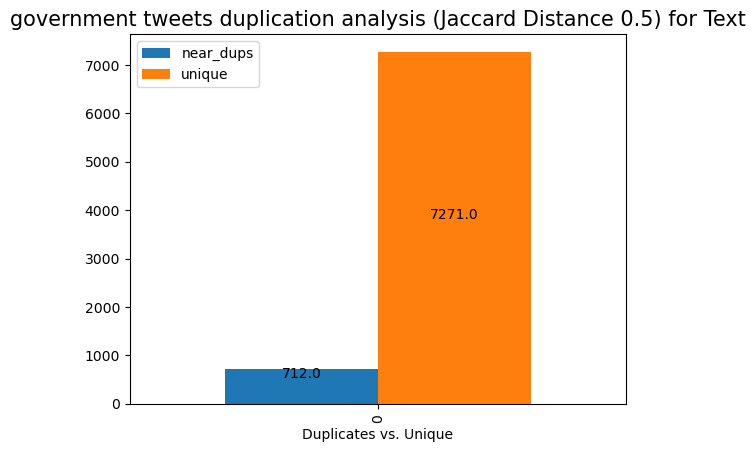

In [26]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('government tweets duplication analysis (Jaccard Distance 0.5) for Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

##### Similarity Analysis on Universities

In [27]:
univ = universities.select(["text"])
univ.limit(5)
# gov = government_entities.select(["text"])

text
@FoxNews It follo...
@JohnHolbein1 Jul...
Hotdogs Most US ...
Brown's MAT stude...
Can experiences w...


In [28]:
text = univ.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")
tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()


In [29]:
row = Row('text')
text_df=text.map(row).zipWithIndex().toDF(['text','id'])
# text_df.limit(5)

In [30]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[@foxnews, it, follows, that, fascists, would, find, classes, in, ""diversity,, equity, and, inclusion"", objectionable, for, college…, https://t.co/hqemeiyahr]",0
1,"[@johnholbein1, julio, angel, alicea,, phd, candidate, in, urban, schooling, at, \n@ucla., am, sociologist, of, education,, race…, https://t.co/zzyudiroxb]",1
2,"[hotdogs, \nmost, us, presidents\nbp\nfirst, interracial, college, \ndesign, of, golf, ball, \nlight, savers, \ngas, mask, \nfish, filet, f…, https://t.co/it2ape6axd]",2
3,"[brown's, mat, students, receive, comprehensive,, critical,, and, equity-based, preparation, for, secondary-school, teaching, ca…, https://t.co/gt9kz1y5jr]",3
4,"[can, experiences, with, religious, diversity, improve, college, students’, attitudes, about, sexual, diversity?, it, turns, out, t…, https://t.co/fpvfojfxw0]",4


In [31]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [32]:

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [33]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left')

In [34]:
jaccard_distance = 0.5

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )


In [35]:
df_dups_txt_30 = df_dups_text_30
# df_dups_text_30.cache()
df_dups_text_30.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.454545,185,673,"(Why does Google racialize universities by policing white supremacy?,)","(Why does Google racialize universities by warping cameras?,)"
1,0.285714,274,1911,"(@NorioFujikawa Hi, I am a PhD student at Howard University conducting a study about BLM on Twitter. You tweeted abo… https://t.co/0NlG90YAJt,)","(@oralia_neria Hi, I am a PhD student at Howard University conducting a study about BLM on Twitter. You tweeted abou… https://t.co/zFFiXvyjJo,)"
2,0.285714,1850,1912,"(@Deschampions2 Hi, I am a PhD student at Howard University conducting a study about BLM on Twitter. You tweeted abo… https://t.co/vkH6g5KjxZ,)","(@xbluerendezvous Hi, I am a PhD student at Howard University conducting a study about BLM on Twitter. You tweeted a… https://t.co/tnncC6f95y,)"
3,0.285714,278,1912,"(@PadsTrashy Hi, I am a PhD student at Howard University conducting a study about BLM on Twitter. You tweeted about… https://t.co/hZTDp6fYfE,)","(@xbluerendezvous Hi, I am a PhD student at Howard University conducting a study about BLM on Twitter. You tweeted a… https://t.co/tnncC6f95y,)"
4,0.285714,162,1914,"(@idekwiadwml Hi, I am a PhD student at Howard University conducting a study about BLM on Twitter. You tweeted about… https://t.co/mHjQ8vJT62,)","(@Rob_Liu Hi, I am a PhD student at Howard University conducting a study about BLM on Twitter. You tweeted about the… https://t.co/CE7nQi7i6G,)"


In [36]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30
print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)


22/12/08 03:17:49 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 38.0 in stage 102.0 (TID 6852) (hub-msca-bdp-dphub-students-backup-zhiliny-sw-qtln.c.msca-bdp-students.internal executor 13): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:550)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:539)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:657)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at sca

Total records:  5650
Duplicate titles based on { 0.5 } jaccard distance:  771
Unique titles based on { 0.5 } jaccard distance:  0.5 :  4879


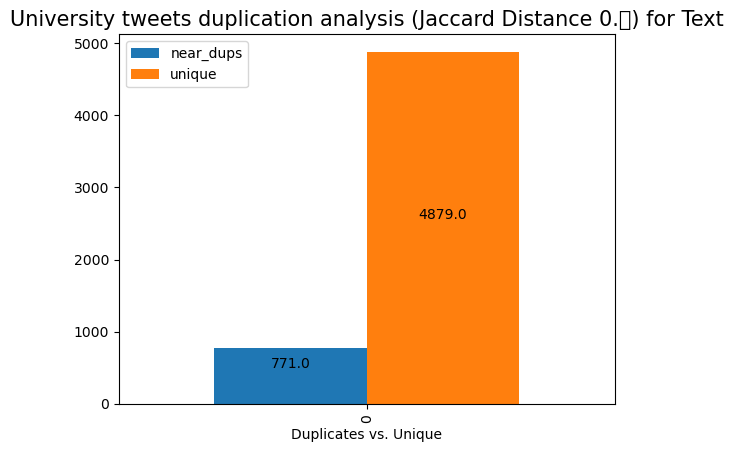

In [37]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques]})
ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('University tweets duplication analysis (Jaccard Distance 0.５) for Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

##### Similarity Analysis on schools

In [38]:
sch = schools.select(["text"])
sch.limit(5)

text
@PennMedicine thi...
.@Edu_Historian: ...
@ClaytonTramel @_...
Sandra Lin 林芍彤 5-...
District 65 Schoo...


In [39]:
text = sch.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

22/12/08 03:22:44 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 105.0 in stage 131.0 (TID 8432) (hub-msca-bdp-dphub-students-backup-zhiliny-sw-dqtm.c.msca-bdp-students.internal executor 22): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:550)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:539)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:657)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.colle

In [40]:
row = Row('text')
text_df=text.map(row).zipWithIndex().toDF(['text','id'])
# text_df.limit(5)

In [41]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[@pennmedicine, this, is, the, dean, of, curriculum, at, you, school, promoting, racial, essentialism?!?!?]",0
1,"[.@edu_historian:, we, simply, don't, have, valid, measures, of, school, quality., they, are, measures, of, family, income,, racial…, https://t.co/yya3nnwosr]",1
2,"[@claytontramel, @_natemorris, radical, gender, theory,, sexual, orientation, training,, and, critical, race, theory, which, has…, https://t.co/sbxoaamrk8]",2
3,"[sandra, lin, 林芍彤, 5-2, is, the, latest, asian, d1, player., she, played, for, georgia, highlands, college, 2020-22, after, graduating…, https://t.co/a9afck8dvm]",3
4,"[district, 65, school, board, welcomes, mya, wilkins, as, its, newest, member., mya, sees, improving, equity, in, education, as, cruci…, https://t.co/y6fl4lpmba]",4


In [42]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)


In [43]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [44]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left')

In [45]:
jaccard_distance = 0.5

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )


In [46]:
df_dups_txt_30 = df_dups_text_30
# df_dups_text_30.cache()
df_dups_text_30.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.333333,2102,5881,"(Graceville High School at sunset and it's 76.3 F. https://t.co/NudJOlt8I5,)","(Graceville High School at sunset and it's 81.7 F. https://t.co/eDB73wsFww,)"
1,0.333333,3161,9630,"(Graceville High School at sunrise and it's 74.5 F. https://t.co/raYbv48I2B,)","(Graceville High School at sunrise and it's 67.7 F. https://t.co/dqTqioNkRS,)"
2,0.461538,3160,5783,"(Graceville High School at sunrise and it's 72.5 F. https://t.co/9wxP0hHIUb,)","(Graceville High School at sunset and it's 82.7 F. https://t.co/ysrNFb6KyJ,)"
3,0.333333,4994,9045,"(Graceville High School at sunrise and it's 75.8 F. https://t.co/KxAU5MChTG,)","(Graceville High School at sunrise and it's 41.5 F. https://t.co/s7mGxSE6qJ,)"
4,0.461538,5881,10257,"(Graceville High School at sunset and it's 81.7 F. https://t.co/eDB73wsFww,)","(Graceville High School at sunrise and it's 50 F. https://t.co/Aivn2T8m8o,)"


In [ ]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30
print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)



22/12/08 03:26:44 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670420302918_0013_01_000004 on host: hub-msca-bdp-dphub-students-backup-zhiliny-sw-ztfh.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-08 03:26:44.849]Container killed on request. Exit code is 143
[2022-12-08 03:26:44.863]Container exited with a non-zero exit code 143. 
[2022-12-08 03:26:44.865]Killed by external signal
.
22/12/08 03:26:44 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670420302918_0013_01_000006 on host: hub-msca-bdp-dphub-students-backup-zhiliny-sw-ztfh.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-08 03:26:44.843]Container killed on request. Exit code is 143
[2022-12-08 03:26:44.845]Container exited with a non-zero exit code 143. 
[2022-12-08 03:26:44.849]Killed by external signal
.
22/12/08 03:26:44 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndp

Total records:  11010
Duplicate titles based on { 0.5 } jaccard distance:  1469
Unique titles based on { 0.5 } jaccard distance:  0.5 :  9541


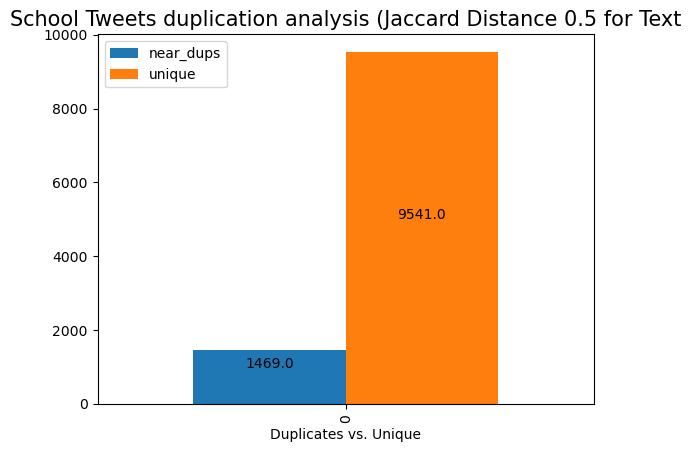

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques]})
ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('School Tweets duplication analysis (Jaccard Distance 0.5 for Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

##### Similarity Analysis on nonprofit organizations

In [ ]:
non = nonprofit_organizations.select(["text"])
non.limit(5)

text
School psychology...
@SpeakinFromTN Fo...
Revenge of the pr...
Our midyear refle...
University endowm...


In [ ]:
text = non.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
text_df=text.map(row).zipWithIndex().toDF(['text','id'])
# text_df.limit(5)

22/12/08 03:35:57 WARN org.apache.spark.network.server.TransportChannelHandler: Exception in connection from /10.128.1.19:53232
java.io.IOException: Connection timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1133)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:148)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650)
	at io.netty.channel.nio.NioEventLoop.proce

In [ ]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[school, psychology, has, diversity, problem,, especially, when, it, comes, to, black, men, npr, https://t.co/3irj7lqszj]",0
1,"[@speakinfromtn, for, the, undercard, races,, i’m, not, very, well, prepared, this, cycle., has, anyone, published, good, summary?…, https://t.co/bq2jnksnrj]",1
2,"[revenge, of, the, privileged, and, the, angry., saying, that, college, admissions, cannot, consider, race, but, can, consider, legac…, https://t.co/yo5jp3qvai]",2
3,"[our, midyear, reflection, asks, what, it, would, take, to, put, equity, at, the, center, of, our, economy,, schools, at, the, center, of…, https://t.co/3xsvngvknk]",3
4,"[university, endowments, brace, for, losses, with, private, equity, values, tumbling, https://t.co/sibymjzwta, via, @crainsdetroit]",4


In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [ ]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left')

In [ ]:
jaccard_distance = 0.5

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [ ]:
df_dups_txt_30 = df_dups_text_30
# df_dups_text_30.cache()
df_dups_text_30.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.095238,366,550,"(If we really want equal opportunities for kids from all races, ethnicities, and family income levels, we must let e… https://t.co/RTagK30nVp,)","(If we really want equal opportunities for kids from all races, ethnicities, and family income levels, we must let e… https://t.co/3rko3zc0ii,)"
1,0.142857,99,209,"(LGBTQ students protected from discrimination, proposed rules say #TitleIX #LGBTQIA #EdChat #k12 https://t.co/wQUPrI2vio,)","(LGBTQ students protected from discrimination, proposed rules say #TitleIX #LGBTQIA #EdChat #k12 https://t.co/RYkg6CVIg2,)"
2,0.200000,464,796,"(@_lesliethomas @Miss_Snuffy @BlackEquityOrg @DavidLammy @TrevorPTweets @CliveMyrieBBC @skygillian @darshnasoni… https://t.co/WDdUgBVsRP,)","(@_lesliethomas @Miss_Snuffy @BlackEquityOrg @DavidLammy @TrevorPTweets @CliveMyrieBBC @skygillian @darshnasoni… https://t.co/1vhqq8A2RD,)"
3,0.142857,639,826,"(New NYC high school admissions rules could slow pandemic-era gains in diversity https://t.co/s9VxwApcGe,)","(New NYC high school admissions rules could slow pandemic-era gains in diversity https://t.co/n03voEZ1X6,)"
4,0.117647,265,538,"(Half the 18 major Southern gubernatorial candidates support restrictions on classroom teaching about race, inequali… https://t.co/FJQntdklSW,)","(Half the 18 major Southern gubernatorial candidates support restrictions on classroom teaching about race, inequali… https://t.co/70Cq98QLtY,)"


In [ ]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30
print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  1042
Duplicate titles based on { 0.5 } jaccard distance:  53
Unique titles based on { 0.5 } jaccard distance:  0.5 :  989


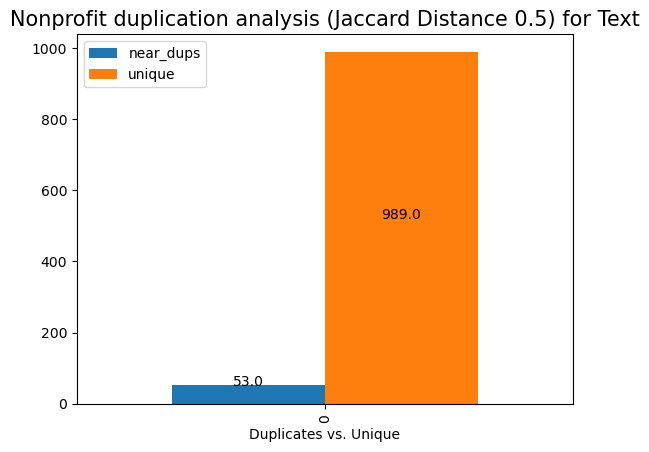

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques]})
ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Nonprofit duplication analysis (Jaccard Distance 0.5) for Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 


##### Similarity Analysis on news outlets

In [ ]:
news = news_outlets.select(["text"])
news.limit(5)

text
@MarshaBlackburn ...
Lawsuit alleges r...
Supreme Court tak...
@WNYT High probab...
US Supreme Court ...


In [ ]:
text = news.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
text_df=text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[@marshablackburn, why???, did, you, not, see, the, disgraceful, mob, that, verbally, attacked, and, threatened, the, williamson, co…, https://t.co/qmjph8jxjb]",0
1,"[lawsuit, alleges, racism, in, burlington, area, school, district, https://t.co/ub8trjptjy, via, @youtube, \n\nfrom, channel, news, milwaukee,, wisconsin]",1
2,"[supreme, court, takes, up, race-conscious, college, admissions, https://t.co/prbyg9emvv]",2
3,"[@wnyt, high, probability, it, gets, struck, down., what’s, happening, to, asian, americans, in, the, college, admission, process, should, be, crime]",3
4,"[us, supreme, court, to, weigh, end, to, race-based, college, admissions\nl:, https://t.co/2ywl3jbytv\nc:, https://t.co/okpoi5x9e6]",4


In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [ ]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left')

In [ ]:
jaccard_distance = 0.5

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
df_dups_txt_30 = df_dups_text_30
# df_dups_text_30.cache()
df_dups_text_30.limit(5).toPandas()

22/12/08 03:43:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1053.1 KiB


,distCol,id_A,id_B,text_A,text_B
0,0.166667,572,10170,"(Talk of race, sex in schools divides Americans: AP-NORC poll https://t.co/znMJaQpNNF,)","(Talk of race, sex in schools divides Americans: AP-NORC poll https://t.co/XRTDY0Jn3d,)"
1,0.375000,1444,13635,"(Talk of race, sex in schools divides Americans: AP-NORC poll || Via AP https://t.co/tppGR0mw21,)","(UPDATE: Talk of race, sex in schools divides Americans: AP-NORC poll https://t.co/M4GoEAbNLu,)"
2,0.222222,1082,5053,"(Supreme Court takes up race-conscious college admissions https://t.co/Dno4c2im50,)","(Supreme Court takes up race-conscious college admissions https://t.co/OHbPreR3Q8,)"
3,0.222222,2796,3551,"(Supreme Court takes up race-conscious college admissions https://t.co/JFwkuNbtQh,)","(Supreme Court Takes Up Race-Conscious College Admissions https://t.co/06p1BKuEbR,)"
4,0.222222,984,6122,"(Supreme Court takes up race-conscious college admissions https://t.co/lStEQmdEYl,)","(Supreme Court Takes Up Race-Conscious College Admissions https://t.co/swJy7QidlX,)"


In [ ]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30
print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

22/12/08 03:46:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1053.1 KiB


Total records:  16359
Duplicate titles based on { 0.5 } jaccard distance:  4392
Unique titles based on { 0.5 } jaccard distance:  0.5 :  11967


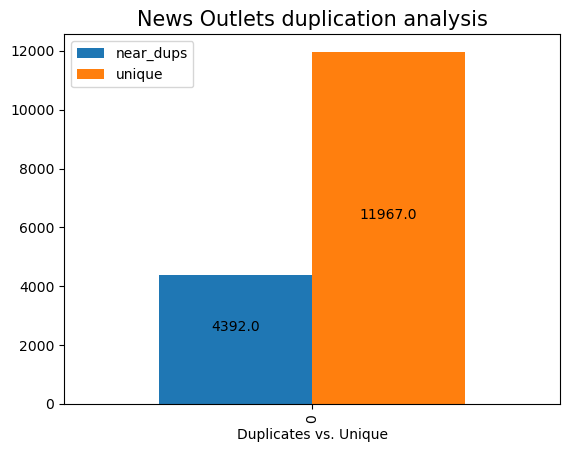

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques]})
ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News Outlets duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

##### Similarity Analysis on social media influencer

In [ ]:
inf = social_media_influencer.select(["text"])
inf.limit(5)

text
RT @uche_blacksto...
RT @LawBeatInd: C...
RT @Littlesubgirl...
"RT @yaf: ""Liberal..."
For back-to-schoo...


In [ ]:
text = inf.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
text_df=text.map(row).zipWithIndex().toDF(['text','id'])

In [ ]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @uche_blackstock:, have, to, constantly, brace, myself, for, anti-blackness, when, open, this, app., \n\ncase, in, point.\n\nthis, physician, is, suggest…]",0
1,"[rt, @lawbeatind:, counsel, (referring, report)girls, from, sc/st, and, muslim, face, the, most, discrimination., non-recognition, of, cultural, and, social…]",1
2,"[rt, @littlesubgirlm:, cute, asian, skips, school, to, rim, &amp;, suck, cock, https://t.co/dxgpgm1kgj\n\n@littlesubgirlm, https://t.co/utbxxonjim]",2
3,"[rt, @yaf:, ""liberals, want, to, criminalize, dissent:, on, election, integrity,, covid-19,, climate,, critical, race, theory, in, schools, if, you, dare, spe…]",3
4,"[for, back-to-school,, @massdph's, vaccine, equity, initiative, is, joining, with, communities, to, host, over, 450, covid-19, vacc…, https://t.co/dmjzysenq5]",4


In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [ ]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left')

In [ ]:
jaccard_distance = 0.5

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [ ]:
df_dups_txt_30 = df_dups_text_30
# df_dups_text_30.cache()
df_dups_text_30.limit(5).toPandas()

22/12/08 03:49:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1328.2 KiB
22/12/08 03:50:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1372.6 KiB
22/12/08 03:50:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1373.5 KiB
22/12/08 03:50:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1473.2 KiB
22/12/08 04:13:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1384.6 KiB
22/12/08 04:13:37 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 352.0 (TID 22186) (hub-msca-bdp-dphub-students-backup-zhiliny-w-1.c.msca-bdp-students.internal executor 43): FetchFailed(BlockManagerId(50, hub-msca-bdp-dphub-students-backup-zhiliny-sw-ztfh.c.msca-bdp-students.internal, 7337, None), shuffleId=85, mapIndex=2, mapId=22168, reduceId=0, message=
org.apache.spark.shuffle.FetchFailedE

,distCol,id_A,id_B,text_A,text_B
0,0.0,228,7901,"(RT @joingles: Trump says we will “get Critical Race Theory out of our classrooms.” Fact check - We haven’t been able to find one k-12 schoo…,)","(RT @joingles: Trump says we will “get Critical Race Theory out of our classrooms.” Fact check - We haven’t been able to find one k-12 schoo…,)"
1,0.0,262,38058,"(RT @santiagomayer_: The news is out: \n\nAs state legislatures try to restrict access to contraception, @VotersTomorrow is going to college c…,)","(RT @santiagomayer_: The news is out: \n\nAs state legislatures try to restrict access to contraception, @VotersTomorrow is going to college c…,)"
2,0.0,149,4734,"(RT @Ccampbellbased: BLM activist Demands Reparations &amp; George Floyd Bill For Schools at Frisco, TX City Council https://t.co/ocgAR08ElE,)","(RT @Ccampbellbased: BLM activist Demands Reparations &amp; George Floyd Bill For Schools at Frisco, TX City Council https://t.co/ocgAR08ElE,)"
3,0.0,110,1793,"(RT @MariahGraceArtt: It’s college graduation season and I want to make it very clear that it is okay if you dropped out,)","(RT @MariahGraceArtt: It’s college graduation season and I want to make it very clear that it is okay if you dropped out,)"
4,0.0,190,23449,"(RT @ACLUFL: BREAKING: We are challenging a Florida law that bans educators and students from discussing race and gender in college classroo…,)","(RT @ACLUFL: BREAKING: We are challenging a Florida law that bans educators and students from discussing race and gender in college classroo…,)"


In [ ]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30
print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

22/12/08 04:15:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1328.2 KiB
22/12/08 04:17:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1372.6 KiB
22/12/08 04:17:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1373.5 KiB
22/12/08 04:17:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1473.2 KiB
22/12/08 04:36:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1383.9 KiB
22/12/08 04:37:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1366.7 KiB


Total records:  43678
Duplicate titles based on { 0.5 } jaccard distance:  22244
Unique titles based on { 0.5 } jaccard distance:  0.5 :  21434


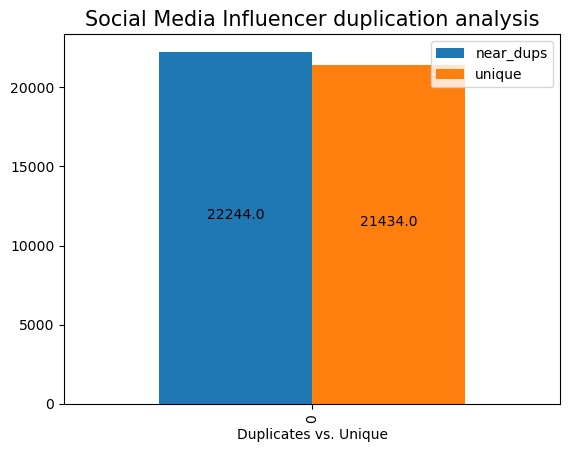

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques]})
ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Social Media Influencer duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 